---
<h1 align="center"><strong>Estimación de un indicador sintético para la economía andaluza</strong></h1>
<h4 align="center"><strong>Carmen Mª Rubio Castaño y Manuel Alej. Hidalgo Pérez</strong></h4>
<h4 align="center"><strong>Universidad Pablo de Olavide</strong></h4>

---

**Descarga de librerías y definición de funciones**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


#FUNCIONES
#Estacionariedad

def make_all_stationary_m(df):
    transformed_df = df.copy()
    transformed_df = transformed_df.apply(np.log)
    
    diff_counts = {}  # Diccionario para almacenar el número de diferenciaciones por columna
    
    for column in transformed_df.columns:
        series = transformed_df[column].dropna()
        
        # Imputa valores faltantes con la media de la serie
        #series = series.fillna(series.mean())
        
        p_value = 1  # Inicializa el p-valor con un valor alto para entrar al bucle
        diff_count = 0  # Contador de veces que se ha diferenciado la serie

        while p_value > 0.05:  # Hasta que la serie sea estacionaria (p-valor menor que 0.05)
            result = adfuller(series)
            p_value = result[1]  # Obtiene el p-valor del test ADF
            
            if p_value > 0.05:  # Si la serie no es estacionaria
                series = series.diff(3).dropna()  # Aplica una diferenciación
                diff_count += 1  # Incrementa el contador de diferenciaciones
        
        transformed_df[column] = series  # Actualiza la columna en el DataFrame transformado
        diff_counts[column] = diff_count  # Almacena el número de diferenciaciones en el diccionario
    
    return transformed_df, diff_counts

def make_all_stationary_q(df):
    transformed_df = df.copy()
    transformed_df = transformed_df.apply(np.log)
    
    diff_counts = {}  # Diccionario para almacenar el número de diferenciaciones por columna
    
    for column in transformed_df.columns:
        series = transformed_df[column]
        
        # Imputa valores faltantes con la media de la serie
        series = series.fillna(series.mean())
        
        p_value = 1  # Inicializa el p-valor con un valor alto para entrar al bucle
        diff_count = 0  # Contador de veces que se ha diferenciado la serie

        while p_value > 0.05:  # Hasta que la serie sea estacionaria (p-valor menor que 0.05)
            result = adfuller(series)
            p_value = result[1]  # Obtiene el p-valor del test ADF
            
            if p_value > 0.05:  # Si la serie no es estacionaria
                series = series.diff().dropna()  # Aplica una diferenciación
                diff_count += 1  # Incrementa el contador de diferenciaciones
        
        transformed_df[column] = series  # Actualiza la columna en el DataFrame transformado
        diff_counts[column] = diff_count  # Almacena el número de diferenciaciones en el diccionario
    
    return transformed_df, diff_counts

# Normalización

def standardize_df(df):
    # Copia el DataFrame para evitar modificar el original
    standardized_df = df.copy()

    
    # Estandariza cada columna del DataFrame
    for column in standardized_df.columns:
        col_mean = standardized_df[column].mean()
        col_std = standardized_df[column].std()
        
        # Aplica la fórmula de estandarización (normalización con media y desviación estándar)
        standardized_df[column] = (standardized_df[column] - col_mean) / col_std
    
    return standardized_df

#Figura Matriz

def figura_matriz(df, l, a, b):
    # Calcula el número de columnas en el DataFrame
    num_columnas = len(df.columns)
    
    # Calcula el número de columnas por fila basado en 'l'
    columnas_por_fila = min(num_columnas, l)
    
    # Calcula el número de filas necesarias
    filas = -(-num_columnas // columnas_por_fila)
    # Define el tamaño de la figura y crea una matriz de subgráficos
    fig, axs = plt.subplots(filas, columnas_por_fila, figsize=(a, b))
    
    # Obtén el nombre de las columnas del DataFrame
    columnas = df.columns
    
    # Itera sobre cada posición en la matriz de subgráficos y grafica las series temporales
    for i in range(filas):
        for j in range(columnas_por_fila):
            idx = i * columnas_por_fila + j
            if idx < num_columnas:  # Evita graficar más columnas de las disponibles
                columna_actual = columnas[idx]
                axs[i, j].plot(df[columna_actual])
                axs[i, j].set_title(columna_actual, fontsize='small')
                xticks = np.arange(0, len(df), 36)
                yticks = np.linspace(df[columna_actual].min(), df[columna_actual].max(), 6)
                axs[i, j].set_xticks(xticks)
                axs[i, j].set_yticks(yticks)
                axs[i, j].tick_params(axis='both', labelsize=6)
            else:
                axs[i, j].axis('off')

    # Ajusta el espaciado entre subgráficos y muestra la figura
    plt.tight_layout()
    plt.show()


In [2]:
import pkg_resources

# Lista de librerías que importas en tu notebook
libraries = [
    'numpy',
    'pandas',
    'matplotlib',
    'statsmodels',
    'scipy'    
    # Añade aquí las demás librerías que utilices
]

# Crear un diccionario con las versiones
versions = {lib: pkg_resources.get_distribution(lib).version for lib in libraries}

# Guardar las versiones en un archivo requirements.txt
with open('requirements.txt', 'w') as file:
    for lib, version in versions.items():
        file.write(f"{lib}=={version}\n")


---
***Preprocesamiento de datos y análisis de correlación***

---

In [3]:
#Importo datos de la excel: los datos fueron suministrados por IECA (04-12-2023)

# Lee el archivo Excel
ruta_archivo = '../Datos/Envío_04_12_2023.xlsx'  # Cambia esto por la ruta de tu archivo Excel


#Series Mensual
nombre_hoja = 'Series_mens_vol_y_desest'  # nombre de la hoja en el archivo Excel
mensual = pd.read_excel(ruta_archivo, sheet_name=nombre_hoja)
# Convierte la columna de fechas al formato deseado (mm-yy)
mensual['fecha'] = pd.to_datetime(mensual['fecha']).dt.strftime('%m-%y')
# Establece la columna 'fecha' como el índice del DataFrame
mensual.set_index('fecha', inplace=True)

#Media movil trimestral
mensual = mensual.rolling(window=3).mean()
mensual = mensual[2:]

#Trimestral

#Mensual
nombre_hoja = 'Serie trim_vol_desest_Índice'  # nombre de la hoja en el archivo Excel
trimestral = pd.read_excel(ruta_archivo, sheet_name=nombre_hoja)
# Convierte la columna de fechas al formato deseado (mm-yy)
trimestral['fecha'] = pd.to_datetime(trimestral['fecha']).dt.strftime('%m-%y')
# Establece la columna 'Fecha' como el índice del DataFrame
trimestral.set_index('fecha', inplace=True)


**Primer paso**

Defino series estacionarias:

Se lleva a cabo transformaciones para alcanzar la estacionaridad en las series temporales. Para ello se generaron versiones mensuales y trimestrales estacionarias de los conjuntos de datos originales, aplicando métodos específicos que ajustan las series para hacerlas estacionarias en términos estadísticos.

Para simplificar y automatizar el proceso, se definió un código que aplicaba las transformaciones mediante un proceso iterativo para cada columna, donde se aplican diferenciaciones sucesivas de tres períodos (tres meses) hasta lograr la estacionaridad. Es decir, siendo $I_t$, el algoritmo analiza si este indicador es estacionario en niveles. Si se rechaza la hipótesis nula de estacionariedad, entonces se procede a calcular su diferenciación según la siguiente expresión: 

$$
dI_t= I_{t}-I_{t-3}
$$

a $dI_t$ se le vuelve a aplicar el test de estacionariedad y si se acepta, el proceso finaliza. Si se rechaza, se vuelve a calcular la diferenciación hasta lograr que la hipótesis nula sea aceptada.

El mismo procedimiento se replica para los datos trimestrales, aunque en este caso con diferenciaciones de un trimestre.

 Una vez finalizado se registra la cantidad de transformaciones necesarias para cada columna, lo que permite identificar y adecuar las series que requieren ajustes más significativos.

Sin embargo, la diferenciación de algunas series no son adecuadamente asignadas por el proceso automático. Es el caso de 'Pernoctaciones - Andalucía', y cuya particular estructura derivada de los meses de COVID dificultan la aplicación de los tests. Es por ello que a esta serie se le asigna manualmente una integración de orden 1.

Estas transformaciones resultaron fundamentales para asegurar la estacionaridad en las series temporales, facilitando un análisis más preciso y apropiado de los datos a lo largo del tiempo.


In [4]:

#Estacionaridad de series 

df_estacionario_mensual, diferencias_por_columna = make_all_stationary_m(mensual)

# Imprime el número de diferenciaciones por cada columna
for column, count in diferencias_por_columna.items():
    print(f"'{column}' fue diferenciada {count} veces.")


df_estacionario_trimestral, diferencias_por_columna = make_all_stationary_q(trimestral)

# Imprime el número de diferenciaciones por cada columna
for column, count in diferencias_por_columna.items():
    print(f"'{column}' fue diferenciada {count} veces.")


df_estacionario_mensual['Pernoctaciones - Andalucía'] = df_estacionario_mensual['Pernoctaciones - Andalucía'].diff(3)
df_estacionario_mensual['Total afiliados SS Total - Andalucía'] = mensual['Total afiliados SS Total - Andalucía'].diff(3)

'Consumo aparente de cemento - Andalucía' fue diferenciada 1 veces.
'Consumo de gasolina y gasóleo' fue diferenciada 1 veces.
'Exportaciones de bienes - Andalucía' fue diferenciada 1 veces.
'Importaciones de bienes - Andalucía' fue diferenciada 1 veces.
'IPIAN Div 23' fue diferenciada 1 veces.
'Índice general de producción industrial - Andalucía' fue diferenciada 1 veces.
'ICMA General sin estaciones de servicios' fue diferenciada 1 veces.
'Matriculación de turismos - Andalucía' fue diferenciada 1 veces.
'Índice ventas grandes superficies - Andalucía' fue diferenciada 2 veces.
'Pernoctaciones - Andalucía' fue diferenciada 0 veces.
'Cifra negocios del sector servicios - Andalucía' fue diferenciada 1 veces.
'Liquidación de presupuestos de la Junta de Andalucía. Capítulo 1 - Andalucía' fue diferenciada 1 veces.
'Total afiliados SS Total - Andalucía' fue diferenciada 2 veces.
'Índice de producción agrícola - Andalucía' fue diferenciada 1 veces.
'pib' fue diferenciada 1 veces.


**Estandarizo**

A continuación estandarizo las series para que la media de cada una de ellas sea cero y la desviación típica sea 1.

In [5]:
# Se aplica la función para estandarizar todas las columnas con media y desviación estándar

endog_m = standardize_df(df_estacionario_mensual)
endog_q = standardize_df(df_estacionario_trimestral)

Los resultados para las series mensuales se pueden observar en la siguiente figura.

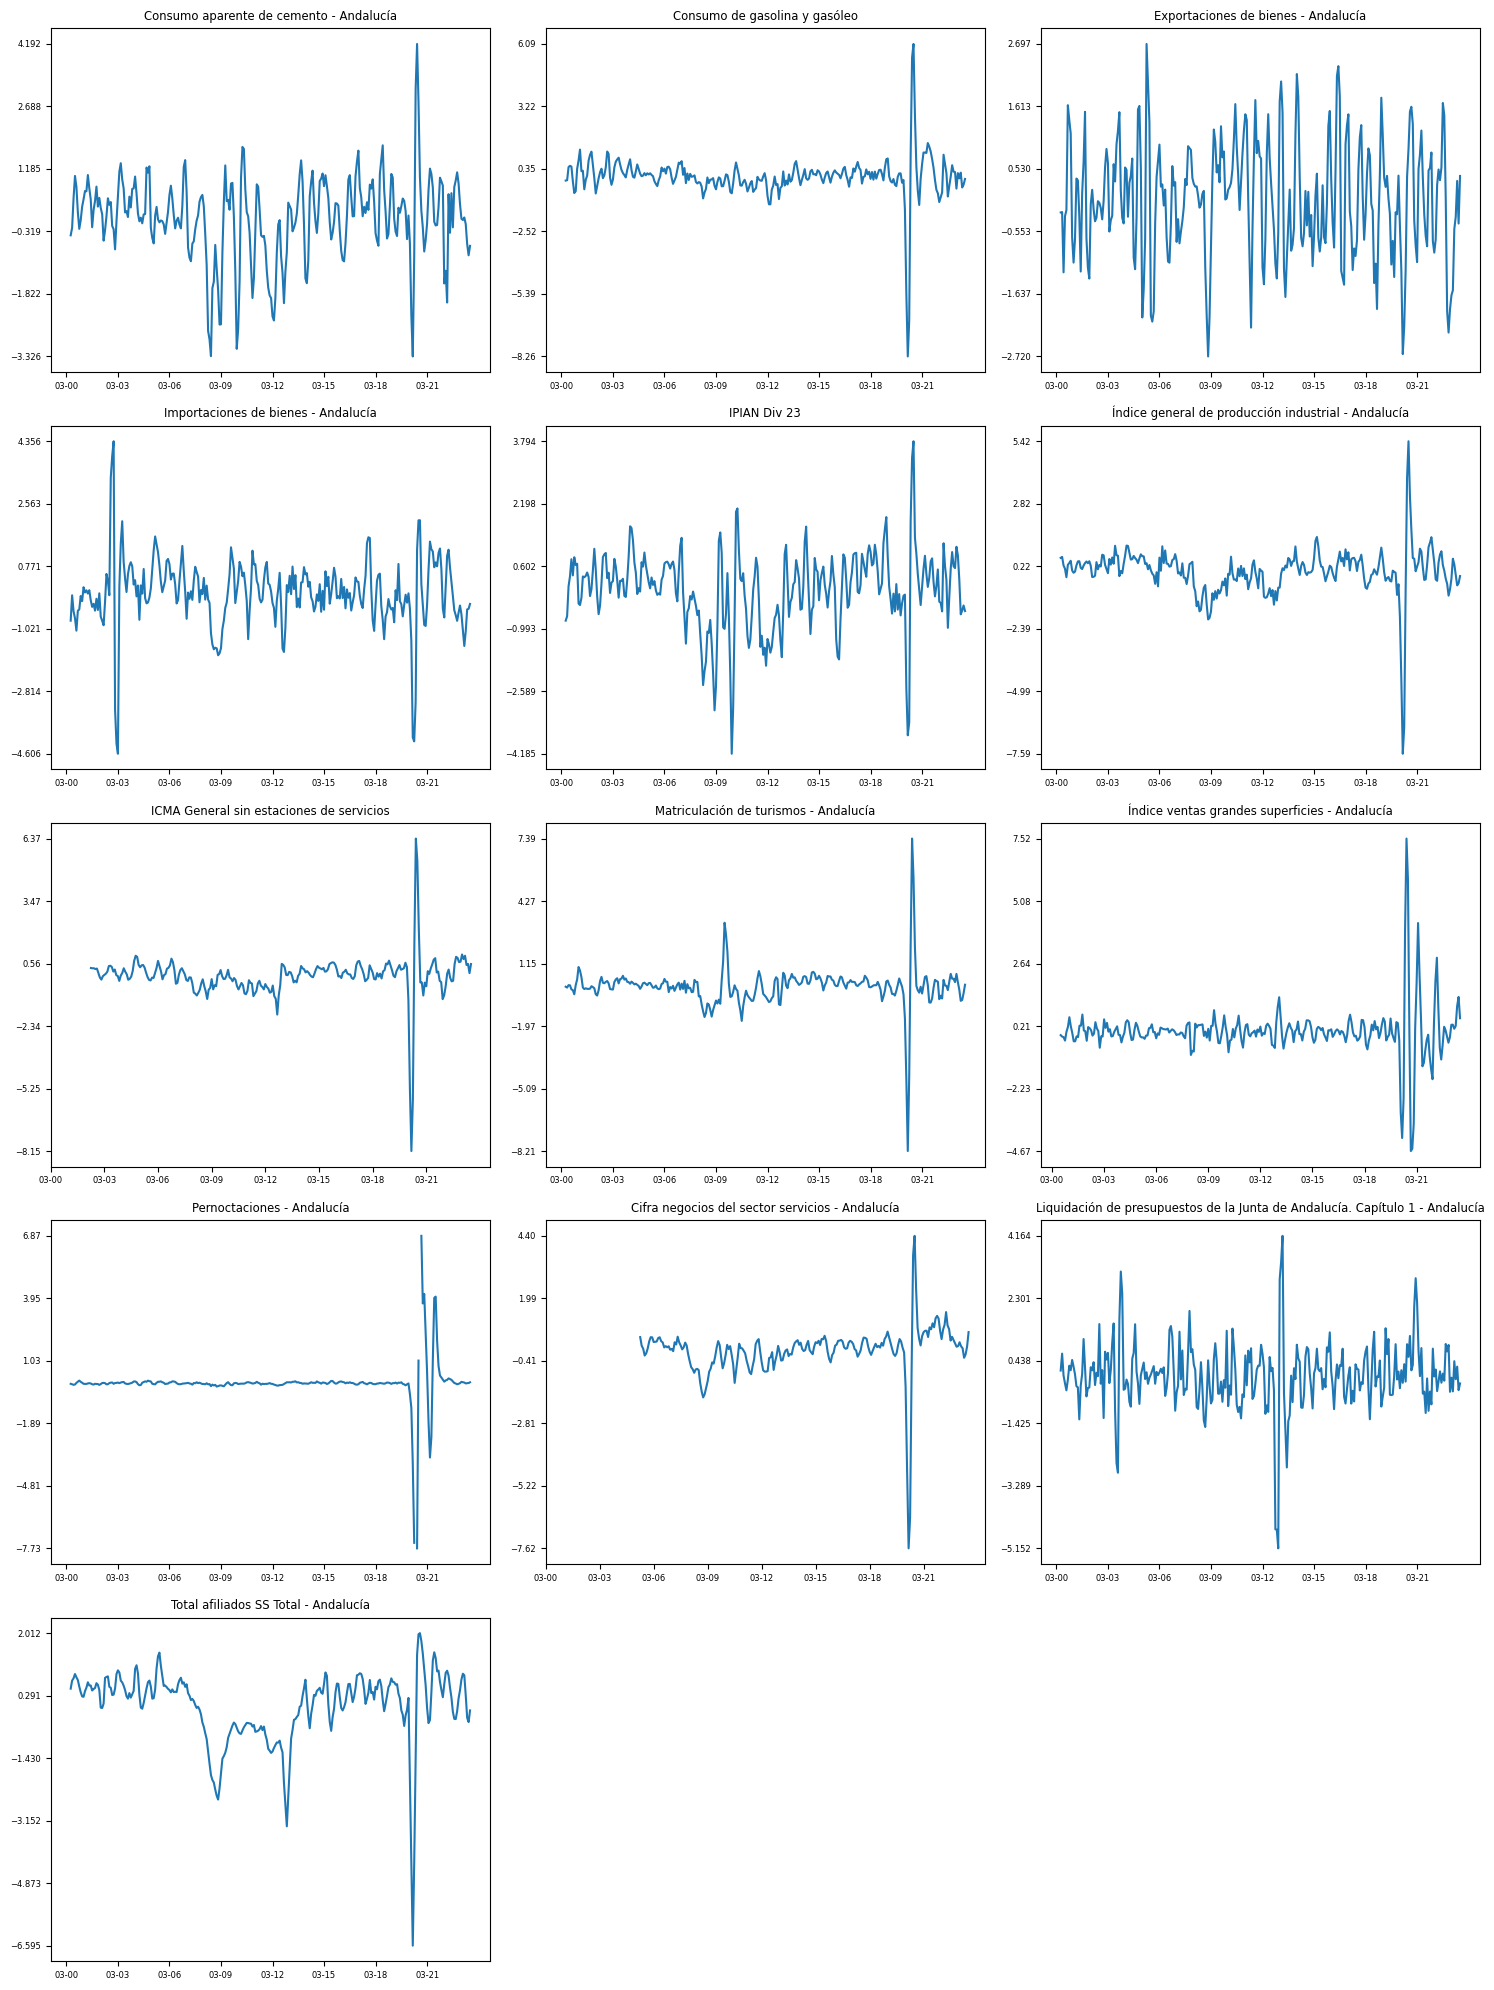

In [6]:
figura_matriz(endog_m, 3, 15, 20)

Para las series trimestrales, PIB e indicador agrícula, se encuentran en la siguiente figura

<Axes: xlabel='fecha'>

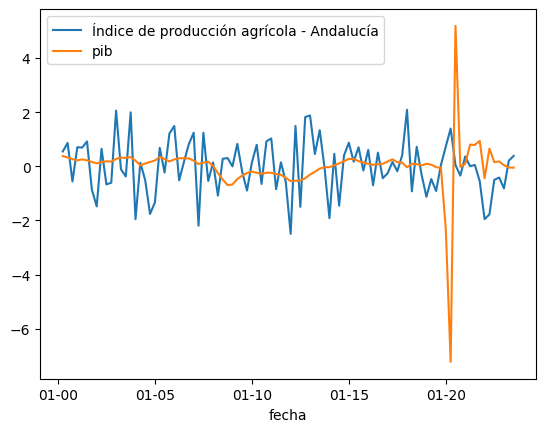

In [7]:
endog_q.plot()

---

**Análisis de identificación de las series**

---

El objetivo de esta sección es el de indentificar mediante el uso de regresiones por mínimos cuadrados (OLS) la capacidad de explicación y, por ello, de aproximación del PIB por los indicadores utilizados en el ejercicio. Este ejercicio solo corresponde a una aprximación previa que se concretará, finalmente, por el uso de métodos de reducción de la dimensionalidad para elaborar un indicador sintético de actividad para la eocnomía andaluza (ISAEA).
Sin embargo, y a pesar de no ser definitivo, este ejercicio permite valorar qué grado de aproximación podemos logar, así como de indicar algunas pistas previas para el ejercicio con el que se quiere contruir finalmente el ISAEA.  

Dado que el indicador objeto de aproximación tiene frecuencia triumestral, lo primero que debemos hacer es transformar los indicadores mensuales a esta frecuencia. 

In [8]:
#Hago merge con datos mensuales "trimestralizados" y el trimestral

# Convertir el índice del DataFrame mensual a formato de fecha y hora
endog_m.index = pd.to_datetime(endog_m.index, format='%m-%y')
# Convertir el índice del DataFrame mensual a formato de fecha y hora
endog_q.index = pd.to_datetime(endog_q.index, format='%m-%y')

# Paso 1: Convertir datos mensuales a trimestrales (tomando el promedio de los valores mensuales)
endog_m_trimestral = endog_m.resample('Q').mean()
endog_q_trimestral = endog_q.resample('Q').mean() #Estos datos se aplica la función a pesar de ser trimestrales para dotarle de mismo formato al dataframe


# Paso 2: Fusionar los datos trimestrales con el DataFrame trimestral existente (endog_q)
merged_data = pd.merge(endog_m_trimestral, endog_q_trimestral, left_index=True, right_index=True, how='inner')



Correlación entre PIB y resto de variables:

Este proceso evalúa la relación de correlación entre el indicador 'pib' y el resto de los indicadores. 

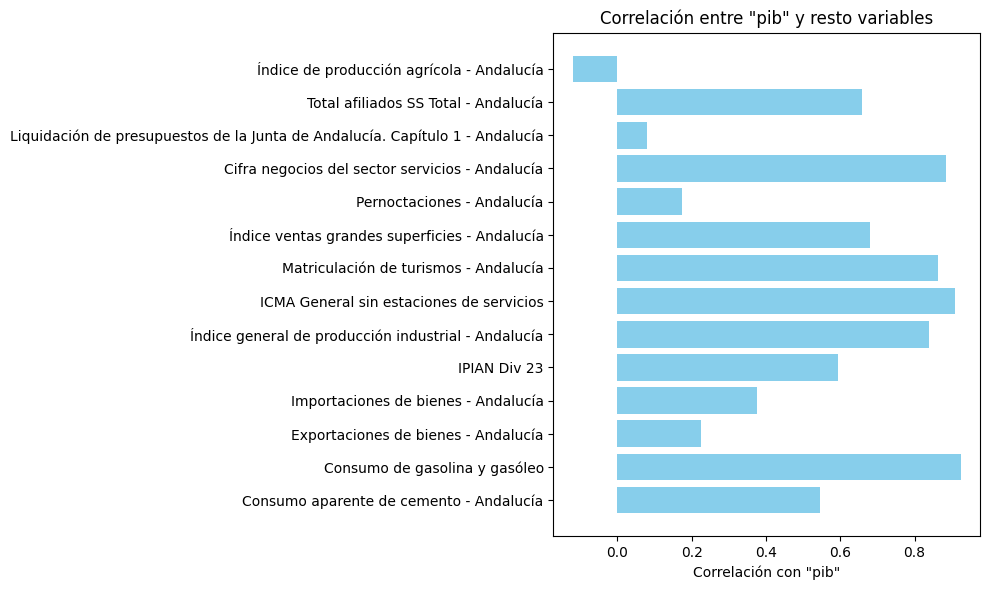

In [9]:

# Realiza una copia del DataFrame para evitar modificar el original
df_copy = merged_data.copy()

# Almacena los nombres de las columnas para la comparación y la correlación
nombres_columnas = merged_data.drop('pib', axis=1).columns.tolist()

# Almacena los valores de correlación
correlaciones = []

for columna in nombres_columnas:
    # Elimina las filas con NaN en 'pib' o en la columna actual para esta iteración
    df_temp = df_copy[['pib', columna]].dropna()
    
    # Calcula la correlación entre 'pib' y la columna actual
    correlacion = df_temp['pib'].corr(df_temp[columna])
    correlaciones.append(correlacion)

# Crea un DataFrame con las correlaciones
df_correlaciones1 = pd.DataFrame({'Columna': nombres_columnas, 'Correlacion con COVID': correlaciones})

# Gráfico de barras de las correlaciones
plt.figure(figsize=(10, 6))
plt.barh(df_correlaciones1['Columna'], df_correlaciones1['Correlacion con COVID'], color='skyblue')
plt.xlabel('Correlación con "pib"')
plt.title('Correlación entre "pib" y resto variables')
plt.tight_layout()
plt.show()


Como se puede observar, la correlación entre los diversos indicadores en la tasa de crecimiento intertrimestral es elevada respecto al PIB, con excepción de los indicadores de producción agrícola, la liquidación de presupuestos y las exportaciones de bienes y servicios.

La primera idea sería utilizar aquellos indicadores con una mayor correlación. Sin embargo, esto podría implicar un posible error por varias razones. En primer lugar, la falta de correlación simplemente indica la incapacidad de ese indicador para aproximar por sí solo la evolución del PIB a lo largo del tiempo. No obstante, esto no indica su capacidad para transmitir información relevante que no sea aportada por el resto de los indicadores. Es posible que su utilidad no sea nula a pesar de esa falta de correlación.

En segundo lugar, debemos considerar que el período desde el primer trimestre de 2020 hasta bien entrado 2021 representa una fase que introduce ruido en las series, dificultando así la evaluación de las relaciones entre estas mediante medidas simples como el coeficiente de correlación u otras similares. Por tanto, el uso de este estadístico para seleccionar los indicadores que mejor puedan aproximar la actividad económica de la región definida por el PIB puede no ser lo más adecuado.

La idea, por ende, es emplear otras aproximaciones que nos permitan, en primer lugar, seleccionar indicadores por su relevancia para replicar la evolución de la actividad económica definida por el PIB y, en segundo lugar, extraer de ellos la información necesaria con la garantía de hacerlo correctamente.

# Selección de mejores indicadores

Por todas estas razones, la estrategia previa para identificar los indicadores preferidos es la de encontrar la combinación de estos que mejor replique la evolución del PIB. Sin embargo, como se ha adelantado, en una posible selección de indicadores que conformen el ISAEA, debemos tener en cuenta LA particularidad que supone la existencia de fuertes "outliers" en torno a los meses de la pandemia. La variación de las series en dichos meses y la fuerte correlación que esto implica con la serie objetivo que es el PIB implica que debamos considerar estrategias de identificación que sean sensibles a este hecho y que, por lo tanto, descarten estadisticos que incorporen dichos meses en su cálculo. Si esto no se hace, se podrá estar cometiendo un error de asignar a una serie una fuerte capacidad de información cuando, en realidad, lo que sucede es que habrá una clara dominancia de la variación de la actividad recogida por dicho indicaor y el PIB entre marzo de 2020 y septiembre de 2020.

Por ejemplo, si realizamos una regresión entre el PIB y todos los indicadores, como se muestra en la siguiente tabla, el coeficiente de determinación será excepcionalmente alto, lo que implica una alta precisión de ese modelo. Sin embargo, este resultado se ve afectado por la multicolinealidad, y debido a que los datos relacionados con la pandemia son extremadamente atípicos, estos dominarán, otorgando una mayor capacidad explicativa a los indicadores que experimentaron una mayor variación durante esos meses, pero no necesariamente una mayor relevancia.

In [10]:
import statsmodels.api as sm

# Supongamos que 'df' es tu DataFrame

# Eliminar las filas con valores NaN
df_clean = merged_data.dropna()

# Separar las variables independientes (X) y la variable dependiente (y)
X = df_clean.drop(['pib', 'Índice de producción agrícola - Andalucía', 'Pernoctaciones - Andalucía'], axis=1)  # Variables independientes
y = df_clean['pib']  # Variable dependiente

# Agregar una constante a las variables independientes (intercepto)
X = sm.add_constant(X)

# Realizar la regresión lineal
modelo1 = sm.OLS(y, X).fit()

# Obtener el resumen del modelo
print(modelo1.summary())



                            OLS Regression Results                            
Dep. Variable:                    pib   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     78.05
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           2.49e-32
Time:                        10:17:56   Log-Likelihood:                -9.5083
No. Observations:                  74   AIC:                             45.02
Df Residuals:                      61   BIC:                             74.97
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

Como se puede apreciar en la figura, la capacidad predictiva del modelo es alta, aunque no hay garantía de que el mejor modelo sea aquel que utiliza todos los indicadores. Además de lo mencionado anteriormente, debemos considerar el riesgo tradicional de sobreajuste en un modelo de regresión, así como el problema de multicolinealidad, que se manifiesta en signos inesperados en indicadores con correlaciones positivas respecto a la variable dependiente.

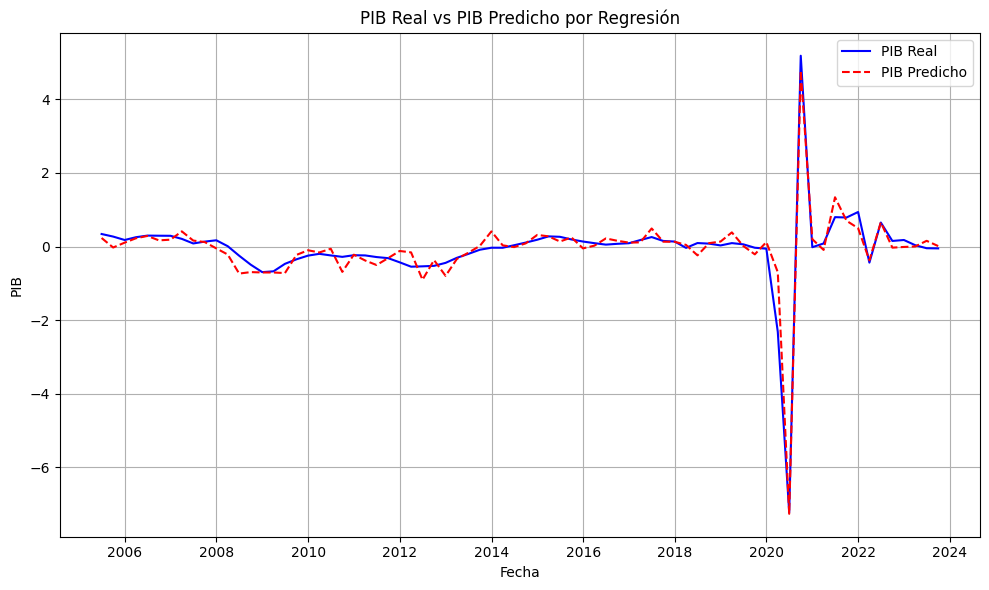

In [11]:

# Predecir los valores de 'pib' usando las variables independientes
prediccion_pib = modelo1.predict(X)

# Graficar 'pib' real y 'pib' predicho
plt.figure(figsize=(10, 6))
plt.plot(df_clean.index, y, label='PIB Real', color='blue')
plt.plot(df_clean.index, prediccion_pib, label='PIB Predicho', color='red', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('PIB')
plt.title('PIB Real vs PIB Predicho por Regresión')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Una prueba de lo que se está comentando, del posible sesgo en la estimación del modelo que supone considerar los meses de la pandemia, se pueden observar en la regresión que se obtendría si esta se realizara con los datos hasta diciembre de 2019. El coeficiente de determinación del modelo decae hasta el 85,9 %, lo que muestra que tratar de aproximar las variables que mejor aproximan al PIB usando las fechas que corresponden a la pandemia no es la mejor estrategia.

In [12]:
import statsmodels.api as sm

# Supongamos que 'df' es tu DataFrame

df_loc = df_clean.loc[:'2019-12-31']

# Separar las variables independientes (X) y la variable dependiente (y)
X = df_loc.drop(['pib', 'Índice de producción agrícola - Andalucía', 'Pernoctaciones - Andalucía'], axis=1)  # Variables independientes
y = df_loc['pib']  # Variable dependiente

# Agregar una constante a las variables independientes (intercepto)
X = sm.add_constant(X)

# Realizar la regresión lineal
modelo2 = sm.OLS(y, X).fit()

# Obtener el resumen del modelo
print(modelo2.summary())



                            OLS Regression Results                            
Dep. Variable:                    pib   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     29.12
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           1.76e-17
Time:                        10:18:03   Log-Likelihood:                 56.163
No. Observations:                  59   AIC:                            -86.33
Df Residuals:                      46   BIC:                            -59.32
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

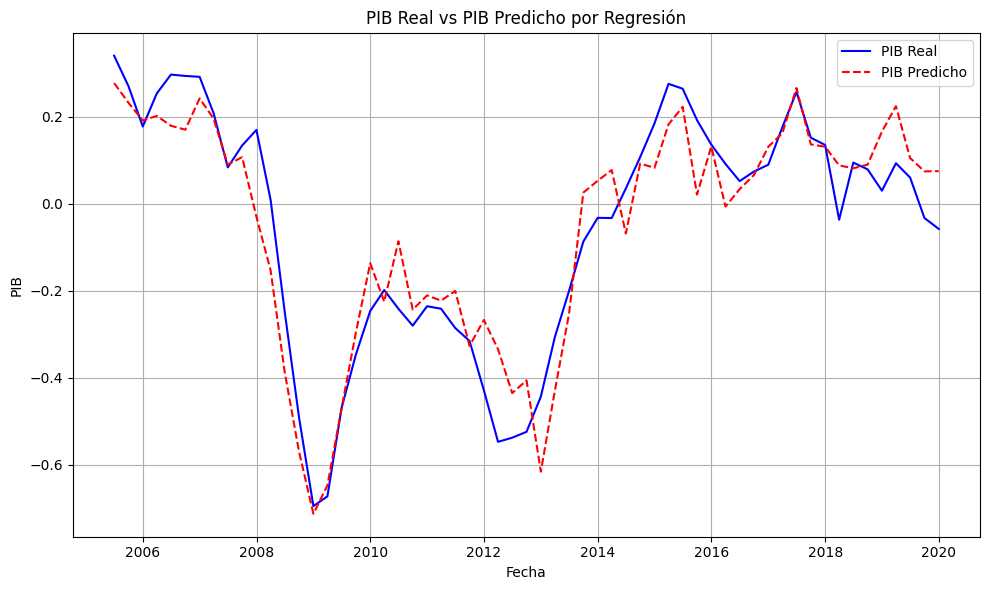

In [13]:

# Predecir los valores de 'pib' usando las variables independientes
prediccion_pib = modelo2.predict(X)

# Graficar 'pib' real y 'pib' predicho
plt.figure(figsize=(10, 6))
plt.plot(df_loc.index, y, label='PIB Real', color='blue')
plt.plot(df_loc.index, prediccion_pib, label='PIB Predicho', color='red', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('PIB')
plt.title('PIB Real vs PIB Predicho por Regresión')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:

# Obtener los parámetros y desviaciones estándar de cada modelo
params_modelo1 = modelo1.params
std_dev_modelo1 = modelo1.bse

params_modelo2 = modelo2.params
std_dev_modelo2 = modelo2.bse

# Crear un DataFrame para comparar los resultados
comparacion = pd.DataFrame({
    'Inc. COVID - Parámetros': params_modelo1,
    'Inc. COVID - Desv. Estándar': std_dev_modelo1,
    'Sin COVID - Parámetros': params_modelo2,
    'Sin COVID - Desv. Estándar': std_dev_modelo2
})

comparacion

,Inc. COVID - Parámetros,Inc. COVID - Desv. Estándar,Sin COVID - Parámetros,Sin COVID - Desv. Estándar
const,-0.009367,0.036902,-0.001375,0.014403
Consumo aparente de cemento - Andalucía,0.001756,0.078716,0.036337,0.030460
Consumo de gasolina y gasóleo,0.545468,0.117290,0.053076,0.070862
Exportaciones de bienes - Andalucía,-0.079041,0.055969,-0.059198,0.021986
Importaciones de bienes - Andalucía,0.030706,0.075713,0.040110,0.034885
IPIAN Div 23,-0.117174,0.082953,-0.020059,0.031077
Índice general de producción industrial - Andalucía,0.141851,0.094677,0.004703,0.042558
ICMA General sin estaciones de servicios,-0.017819,0.117797,0.105439,0.055011
Matriculación de turismos - Andalucía,0.094053,0.087849,-0.044552,0.037399
Índice ventas grandes superficies - Andalucía,0.257174,0.056475,-0.036974,0.071778


No obstante, la correlación de las distintas series hasta el cuarto trimestre de 2019 son evidentes y elevadas para algunos indicadores

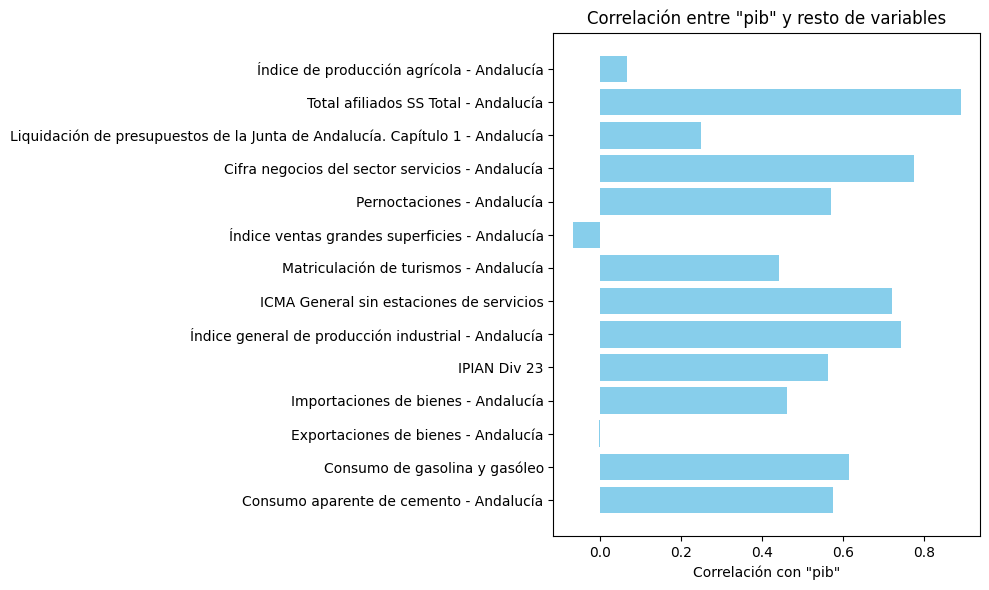

In [15]:
# Dividir el DataFrame en conjuntos de entrenamiento y prueba
train_df = df_clean.loc[:'2019-12-31']
test_df = df_clean.loc['2021-03-31':'2023-09-30']

# Almacena los nombres de las columnas para la comparación y la correlación
nombres_columnas = train_df.drop('pib', axis=1).columns.tolist()

# Almacena los valores de correlación
correlaciones = []

for columna in nombres_columnas:
    # Elimina las filas con NaN en 'pib' o en la columna actual para esta iteración
    df_temp = train_df[['pib', columna]].dropna()
    
    # Calcula la correlación entre 'pib' y la columna actual
    correlacion = train_df['pib'].corr(train_df[columna])
    correlaciones.append(correlacion)

# Crea un DataFrame con las correlaciones
df_correlaciones2 = pd.DataFrame({'Columna': nombres_columnas, 'Correlacion sin COVID': correlaciones})

# Gráfico de barras de las correlaciones
plt.figure(figsize=(10, 6))
plt.barh(df_correlaciones2['Columna'], df_correlaciones2['Correlacion sin COVID'], color='skyblue')
plt.xlabel('Correlación con "pib"')
plt.title('Correlación entre "pib" y resto de variables')
plt.tight_layout()
plt.show()


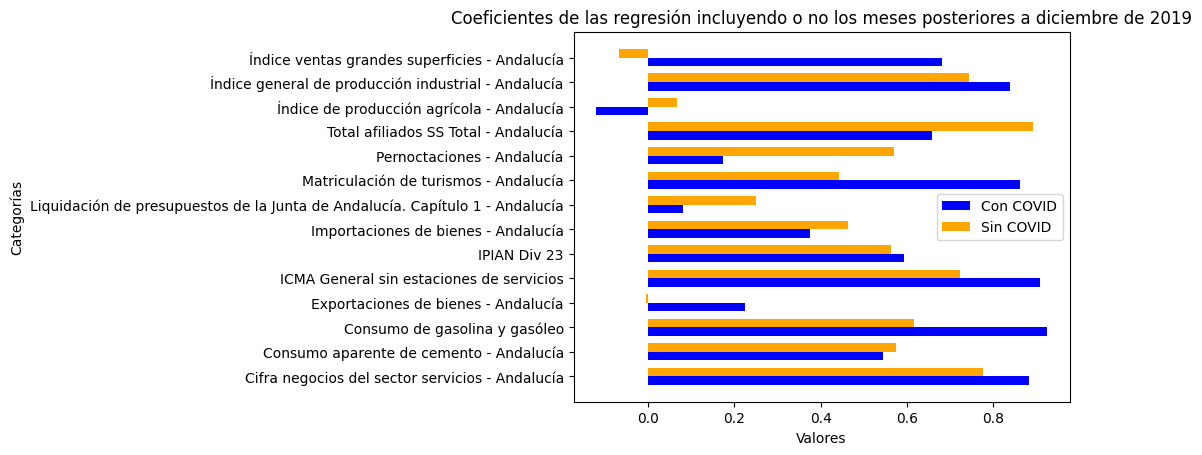

In [16]:
correlaciones = pd.merge(df_correlaciones1, df_correlaciones2, on='Columna')

# Agrupar los datos por la columna 'columna'
grupos = correlaciones.groupby('Columna')

# Obtener las categorías y sus índices para el gráfico
categorias = grupos.groups.keys()
indices = range(len(categorias))

# Configurar los valores para las barras
valores1 = [grupos.get_group(cat)['Correlacion con COVID'].mean() for cat in categorias]
valores2 = [grupos.get_group(cat)['Correlacion sin COVID'].mean() for cat in categorias]

# Crear el gráfico de barras horizontal
ancho_barras = 0.35
plt.barh(indices, valores1, height=ancho_barras, label='Con COVID', color='blue')
plt.barh([i + ancho_barras for i in indices], valores2, height=ancho_barras, label='Sin COVID', color='orange')

# Configurar ejes y etiquetas
plt.yticks([i + ancho_barras / 2 for i in indices], categorias)
plt.xlabel('Valores')
plt.ylabel('Categorías')
plt.title('Coeficientes de las regresión incluyendo o no los meses posteriores a diciembre de 2019')
plt.legend()

# Mostrar el gráfico
plt.show()


# Búsqueda iterativa del mejor modelo

In [17]:
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Definir tu lista de 13 regresores
regresores = ['Exportaciones de bienes - Andalucía', 'Importaciones de bienes - Andalucía', 'Pernoctaciones - Andalucía',
              'Liquidación de presupuestos de la Junta de Andalucía. Capítulo 1 - Andalucía',
              'Total afiliados SS Total - Andalucía', 'Índice de producción agrícola - Andalucía',
              'Matriculación de turismos - Andalucía', 'Consumo aparente de cemento - Andalucía',
              'Consumo de gasolina y gasóleo', 'Índice general de producción industrial - Andalucía',
              'ICMA General sin estaciones de servicios', 'Cifra negocios del sector servicios - Andalucía',
              'IPIAN Div 23']

# Definir el conjunto de fechas para separar train y test
fecha_train = '2019-12-31'
fecha_test_inicio = '2020-03-31'
fecha_test_fin = '2023-09-30'

# Inicializar variables para almacenar el mejor modelo y su MSE
mejor_modelo = None
menor_mse = float('inf')  # Inicializar con un valor grande

# Crear un diccionario para almacenar las combinaciones con menor MSE para cada valor de i
mejores_combinaciones = {}
mejores_combinaciones_metrica = {}

for i in range(3,12):
    # Convertir las combinaciones en una lista para obtener la longitud
    combinaciones_regresores = list(combinations(regresores, i))

    # Inicializar una barra de progreso
    pbar = tqdm(total=len(combinaciones_regresores), desc='Progreso')

    menor_mse_i = float('inf')  # Inicializar el menor MSE para este i
    mejor_combinacion_i = None  # Inicializar la mejor combinación para este i

    menor_metrica_i = float('inf')  # Inicializar la menor métrica para este i
    mejor_combinacion_metrica_i = None  # Inicializar la mejor combinación para este i


    # Iterar sobre cada combinación de regresores
    for combinacion in combinaciones_regresores:
        # Obtener los nombres de los regresores para esta combinación
        regresores_combinacion = list(combinacion)
        
        # Filtrar el DataFrame con solo los regresores de esta combinación
        train_data = df_clean.loc[:fecha_train]
        test_data = df_clean.loc[fecha_test_inicio:fecha_test_fin]

        # Separar los datos en variables independientes y dependiente para entrenamiento y prueba
        X_train = train_data[regresores_combinacion]  # Reemplaza 'variable_dependiente' por tu variable exógena
        y_train = train_data['pib']  # Reemplaza 'variable_dependiente' por tu variable exógena
        X_test = test_data[regresores_combinacion]  # Reemplaza 'variable_dependiente' por tu variable exógena
        y_test = test_data['pib']  # Reemplaza 'variable_dependiente' por tu variable exógena

        # Inicializar y ajustar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(X_train, y_train)

        # Realizar predicciones en el conjunto de prueba y calcular el MSE
        prediccion = modelo.predict(X_test)
        mse = mean_squared_error(y_test, prediccion)

        # Actualizar el mejor modelo si encontramos un MSE menor para todo i y combinaciones
        if mse < menor_mse:
            menor_mse = mse
            mejor_modelo = modelo
            mejores_regresores = regresores_combinacion
            
        if mse < menor_mse_i:
            menor_mse_i = mse
            mejor_combinacion_i = regresores_combinacion


        # Evalúo el cambio de signo

        
        # Convertir las predicciones y datos de prueba a DataFrames de pandas
        y_test_df = pd.Series(y_test)
        prediccion_df = pd.Series(prediccion)

        # Evaluar el cambio de signo entre las predicciones y los datos de prueba
        diferencia_signo = abs((y_test_df.diff().fillna(0).values > 0) != (prediccion_df.diff().fillna(0) > 0))
        metrica = diferencia_signo.mean()  # Calcular la métrica

        if metrica < menor_metrica_i:
            menor_metrica_i = metrica
            mejor_combinacion_metrica_i = regresores_combinacion
        
        # Actualizar la barra de progreso
        pbar.update(1)  # Incrementar el progreso en 1 unidad
        pbar.set_postfix(Completado=f"{pbar.n}/{pbar.total}")  # Mostrar el progreso actual
    
    # Almacenar la mejor combinación para este i en el diccionario
    mejores_combinaciones[i] = {'Mejor_Combinacion': mejor_combinacion_i, 'Menor_MSE': menor_mse_i}
    mejores_combinaciones_metrica[i] = {'Mejor_Combinacion': mejor_combinacion_metrica_i, 'Menor_MSE': menor_metrica_i}

    pbar.close()  # Cerrar la barra de progreso al finalizar

# Convertir el diccionario a un DataFrame
df_mejores_combinaciones = pd.DataFrame.from_dict(mejores_combinaciones, orient='index')
df_mejores_combinaciones_metrica = pd.DataFrame.from_dict(mejores_combinaciones_metrica, orient='index')

# Mostrar la combinación de regresores con el menor MSE en el conjunto de prueba
print(f"La mejor combinación de regresores es: {mejores_regresores}")
print(f"El MSE más bajo en el conjunto de prueba es: {menor_mse}")



Progreso: 100%|██████████| 78/78 [00:00<00:00, 173.79it/s, Completado=78/78]

La mejor combinación de regresores es: ['Exportaciones de bienes - Andalucía', 'Matriculación de turismos - Andalucía', 'Consumo de gasolina y gasóleo', 'ICMA General sin estaciones de servicios']
El MSE más bajo en el conjunto de prueba es: 1.5330848431510884


In [18]:
# Separar las variables independientes (X) y la variable dependiente (y)
X = df_clean[mejores_regresores]
y = df_clean['pib']  # Variable dependiente

# Agregar una constante a las variables independientes (intercepto)
X = sm.add_constant(X)

# Realizar la regresión lineal
modelo = sm.OLS(y, X).fit()

# Obtener el resumen del modelo
print(modelo.summary())



                            OLS Regression Results                            
Dep. Variable:                    pib   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     158.3
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           5.52e-34
Time:                        10:20:46   Log-Likelihood:                -27.054
No. Observations:                  74   AIC:                             64.11
Df Residuals:                      69   BIC:                             75.63
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

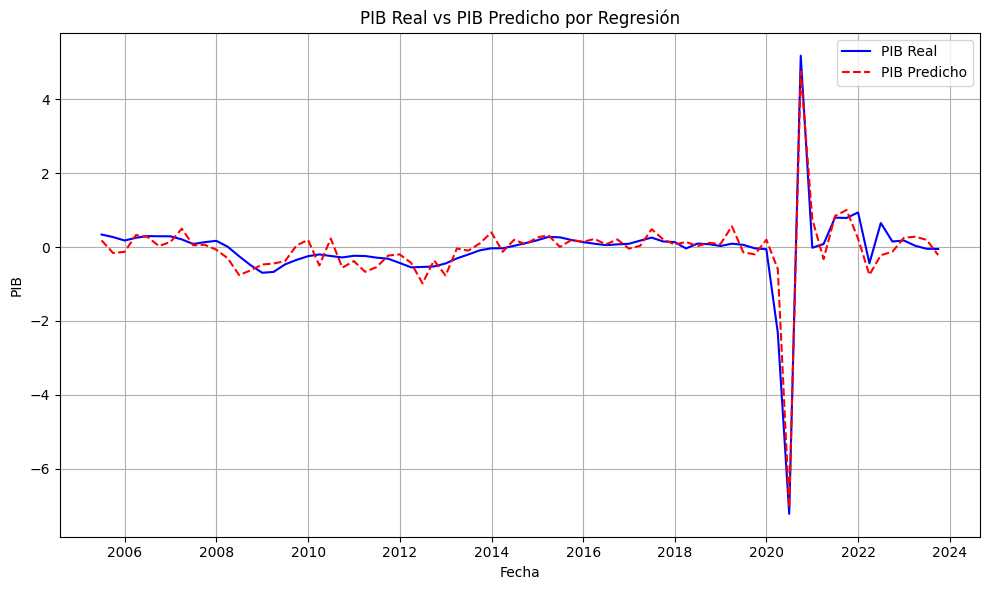

In [19]:

# Predecir los valores de 'pib' usando las variables independientes
prediccion_pib = modelo.predict(X)

# Graficar 'pib' real y 'pib' predicho
plt.figure(figsize=(10, 6))
plt.plot(df_clean.index, y, label='PIB Real', color='blue')
plt.plot(df_clean.index, prediccion_pib, label='PIB Predicho', color='red', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('PIB')
plt.title('PIB Real vs PIB Predicho por Regresión')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:

# Definir el conjunto de fechas para separar train y test
fecha_train = '2019-12-31'
fecha_test_inicio = '2021-03-31'
fecha_test_fin = '2023-09-30'

# Inicializar variables para almacenar el mejor modelo y su MSE
mejor_modelo = None
menor_mse = float('inf')  # Inicializar con un valor grande

# Crear un diccionario para almacenar las combinaciones con menor MSE para cada valor de i
mejores_combinaciones = {}
mejores_combinaciones_metrica = {}

for i in range(3,12):
    # Convertir las combinaciones en una lista para obtener la longitud
    combinaciones_regresores = list(combinations(regresores, i))

    # Inicializar una barra de progreso
    pbar = tqdm(total=len(combinaciones_regresores), desc='Progreso')

    menor_mse_i = float('inf')  # Inicializar el menor MSE para este i
    mejor_combinacion_i = None  # Inicializar la mejor combinación para este i

    menor_metrica_i = float('inf')  # Inicializar la menor métrica para este i
    mejor_combinacion_metrica_i = None  # Inicializar la mejor combinación para este i


    # Iterar sobre cada combinación de regresores
    for combinacion in combinaciones_regresores:
        # Obtener los nombres de los regresores para esta combinación
        regresores_combinacion = list(combinacion)
        
        # Filtrar el DataFrame con solo los regresores de esta combinación
        train_data = df_clean.loc[:fecha_train]
        test_data = df_clean.loc[fecha_test_inicio:fecha_test_fin]

        # Separar los datos en variables independientes y dependiente para entrenamiento y prueba
        X_train = train_data[regresores_combinacion]  # Reemplaza 'variable_dependiente' por tu variable exógena
        y_train = train_data['pib']  # Reemplaza 'variable_dependiente' por tu variable exógena
        X_test = test_data[regresores_combinacion]  # Reemplaza 'variable_dependiente' por tu variable exógena
        y_test = test_data['pib']  # Reemplaza 'variable_dependiente' por tu variable exógena

        # Inicializar y ajustar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(X_train, y_train)

        # Realizar predicciones en el conjunto de prueba y calcular el MSE
        prediccion = modelo.predict(X_test)
        mse = mean_squared_error(y_test, prediccion)

        # Actualizar el mejor modelo si encontramos un MSE menor para todo i y combinaciones
        if mse < menor_mse:
            menor_mse = mse
            mejor_modelo = modelo
            mejores_regresores = regresores_combinacion
            
        if mse < menor_mse_i:
            menor_mse_i = mse
            mejor_combinacion_i = regresores_combinacion


        # Evalúo el cambio de signo

        
        # Convertir las predicciones y datos de prueba a DataFrames de pandas
        y_test_df = pd.Series(y_test)
        prediccion_df = pd.Series(prediccion)

        # Evaluar el cambio de signo entre las predicciones y los datos de prueba
        diferencia_signo = abs((y_test_df.diff().fillna(0).values > 0) != (prediccion_df.diff().fillna(0) > 0))
        metrica = diferencia_signo.mean()  # Calcular la métrica

        if metrica < menor_metrica_i:
            menor_metrica_i = metrica
            mejor_combinacion_metrica_i = regresores_combinacion
        
        # Actualizar la barra de progreso
        pbar.update(1)  # Incrementar el progreso en 1 unidad
        pbar.set_postfix(Completado=f"{pbar.n}/{pbar.total}")  # Mostrar el progreso actual
    
    # Almacenar la mejor combinación para este i en el diccionario
    mejores_combinaciones[i] = {'Mejor_Combinacion': mejor_combinacion_i, 'Menor_MSE': menor_mse_i}
    mejores_combinaciones_metrica[i] = {'Mejor_Combinacion': mejor_combinacion_metrica_i, 'Menor_MSE': menor_metrica_i}

    pbar.close()  # Cerrar la barra de progreso al finalizar

# Convertir el diccionario a un DataFrame
df_mejores_combinaciones = pd.DataFrame.from_dict(mejores_combinaciones, orient='index')
df_mejores_combinaciones_metrica = pd.DataFrame.from_dict(mejores_combinaciones_metrica, orient='index')

# Mostrar la combinación de regresores con el menor MSE en el conjunto de prueba
print(f"La mejor combinación de regresores es: {mejores_regresores}")
print(f"El MSE más bajo en el conjunto de prueba es: {menor_mse}")



Progreso: 100%|██████████| 78/78 [00:00<00:00, 188.56it/s, Completado=78/78]

La mejor combinación de regresores es: ['Exportaciones de bienes - Andalucía', 'Importaciones de bienes - Andalucía', 'Índice de producción agrícola - Andalucía', 'Matriculación de turismos - Andalucía', 'Consumo de gasolina y gasóleo', 'Cifra negocios del sector servicios - Andalucía']
El MSE más bajo en el conjunto de prueba es: 0.04739233567861232


In [21]:
# Separar las variables independientes (X) y la variable dependiente (y)
X = df_clean[mejores_regresores]
y = df_clean['pib']  # Variable dependiente

# Agregar una constante a las variables independientes (intercepto)
X = sm.add_constant(X)

# Realizar la regresión lineal
modelo = sm.OLS(y, X).fit()

# Obtener el resumen del modelo
print(modelo.summary())



                            OLS Regression Results                            
Dep. Variable:                    pib   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     116.0
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           2.06e-33
Time:                        10:22:23   Log-Likelihood:                -22.888
No. Observations:                  74   AIC:                             59.78
Df Residuals:                      67   BIC:                             75.90
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

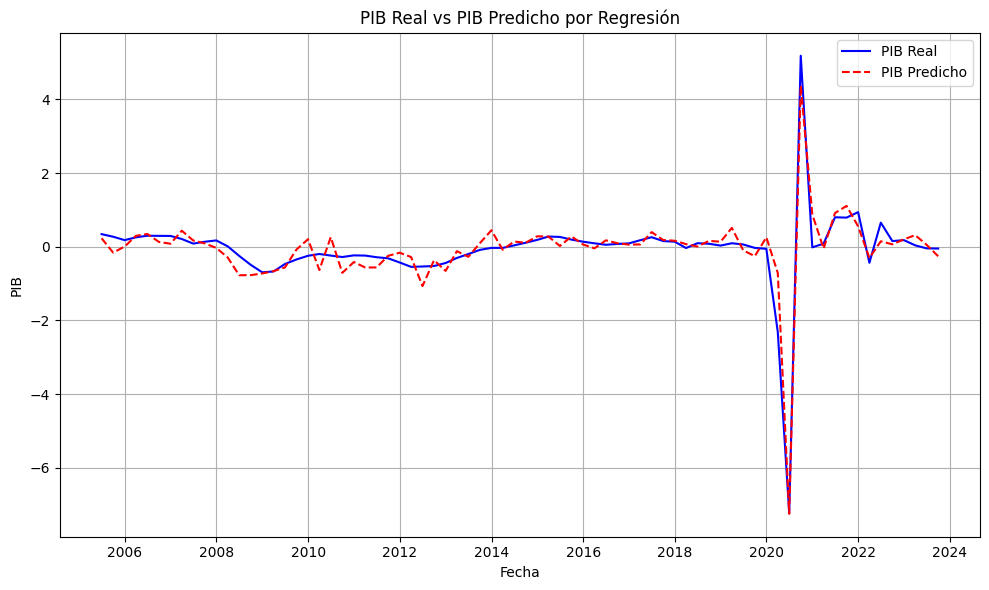

In [22]:

# Predecir los valores de 'pib' usando las variables independientes
prediccion_pib = modelo.predict(X)

# Graficar 'pib' real y 'pib' predicho
plt.figure(figsize=(10, 6))
plt.plot(df_clean.index, y, label='PIB Real', color='blue')
plt.plot(df_clean.index, prediccion_pib, label='PIB Predicho', color='red', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('PIB')
plt.title('PIB Real vs PIB Predicho por Regresión')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

# DMFQ

---

In [23]:
endog_q.index = endog_q.index.to_period('Q')
endog_m.index = endog_m.index.to_period('M')

Este código realiza un análisis para encontrar el mejor modelo predictivo utilizando regresión lineal. Aquí está una explicación detallada de lo que hace:

1. **Definición de regresores:** Se crea una lista llamada `regresores` que contiene los nombres de las 13 variables independientes que se utilizarán como regresores en el modelo. Estas variables son de nuevo las suministradas por el IECA.

2. **Combinaciones de regresores:** Se generan todas las combinaciones posibles de 6 regresores a partir de la lista definida anteriormente.

3. **Inicialización de variables:** Se inicializan variables para almacenar el mejor modelo y su Error Cuadrático Medio (MSE), así como un diccionario para almacenar las combinaciones con el menor MSE para cada valor de i.

4. **Iteración sobre las combinaciones de regresores:** Se itera sobre cada combinación de regresores generada previamente.

5. **Preprocesamiento de datos:** Se eliminan las filas con valores faltantes y se ajusta un conjunto de datos a otro.

6. **Ajuste del modelo:** Se ajusta un modelo utilizando ciertas especificaciones.

7. **Predicción:** Se utilizan los coeficientes del modelo para realizar predicciones sobre ciertas variables, entre ellas la que nos interesa es la previsión del PIB.

8. **Cálculo del MSE:** Se calcula el Error Cuadrático Medio (MSE) comparando las predicciones con los valores reales de ciertas variables.

9. **Actualización del mejor modelo:** Si el MSE actual es menor que el MSE almacenado previamente, se actualizan las variables que almacenan el mejor modelo y su MSE.

Así pues, este código busca encontrar la mejor combinación de regresores para predecir ciertas variables utilizando modelos de factores dinámicos, ajustando y evaluando varios modelos y seleccionando aquellos que minimizan el MSE en el conjunto de prueba.

In [24]:
from itertools import combinations

# Definir tu lista de 13 regresores
regresores = ['Exportaciones de bienes - Andalucía', 'Importaciones de bienes - Andalucía', 'Pernoctaciones - Andalucía',
              'Liquidación de presupuestos de la Junta de Andalucía. Capítulo 1 - Andalucía',
              'Total afiliados SS Total - Andalucía', 'Índice de producción agrícola - Andalucía',
              'Matriculación de turismos - Andalucía', 'Consumo aparente de cemento - Andalucía',
              'Consumo de gasolina y gasóleo', 'Índice general de producción industrial - Andalucía',
              'ICMA General sin estaciones de servicios', 'Cifra negocios del sector servicios - Andalucía',
              'IPIAN Div 23']

# Inicializar variables para almacenar el mejor modelo y su MSE
mejor_modelo = None
menor_mse = float('inf')  # Inicializar con un valor grande

# Crear un diccionario para almacenar las combinaciones con menor MSE para cada valor de i
mejores_combinaciones = {}

for i in range(3,12):

    # Convertir las combinaciones en una lista para obtener la longitud

    combinaciones_regresores = list(combinations(regresores, i))
    print(len(combinaciones_regresores))

    # Inicializar una barra de progreso
    pbar = tqdm(total=len(combinaciones_regresores), desc='Progreso')

    # Iterar sobre cada combinación de regresores
    for combinacion in combinaciones_regresores:
        # Obtener los nombres de los regresores para esta combinación
        regresores_combinacion = list(combinacion)
        
        elemento_a_eliminar = 'Índice de producción agrícola - Andalucía'
        if elemento_a_eliminar in regresores_combinacion:
            regresores_combinacion.remove(elemento_a_eliminar)

        endog_m_c = endog_m[regresores_combinacion].dropna()



        endog_q=endog_q[['pib']]
        mod = sm.tsa.DynamicFactorMQ(endog_m_c, 
                                    endog_quarterly=endog_q, 
                                    factor_orders = 2, 
                                    factors=2,
                                    idiosyncratic_ar1=False)
        res = mod.fit()



        y_true=endog_q['pib']
        y_true=y_true['2002Q1':'2023Q3']

        X_Q = res.factors.smoothed.resample('Q').mean().loc['2002Q1':'2023Q3']

        # Realizar la regresión lineal
        modelo = sm.OLS(y_true, X_Q).fit()

            
        # Convertir el índice a una cadena de texto en formato trimestral
        y_true.index = y_true.index.to_timestamp().to_period('Q').strftime('%YQ%q')

        # Obtener la predicción del modelo
        y_pred = modelo.predict(X_Q)


        mse = mean_squared_error(y_true.loc['2021Q1':'2023Q3'], y_pred.loc['2021Q1':'2023Q3'])


        
        # Actualizar el mejor modelo si encontramos un MSE menor para todo i y combinaciones
        if mse < menor_mse:
            menor_mse = mse
            mejor_modelo = modelo
            mejores_regresores = regresores_combinacion
            mejor_res = res

        # Actualizar la barra de progreso
        pbar.update(1)  # Incrementar el progreso en 1 unidad
        pbar.set_postfix(Completado=f"{pbar.n}/{pbar.total}")  # Mostrar el progreso actual

    pbar.close()  # Cerrar la barra de progreso al finalizar

# Mostrar la combinación de regresores con el menor MSE en el conjunto de prueba
print(f"La mejor combinación de regresores es: {mejores_regresores}")
print(f"El MSE más bajo en el conjunto de prueba es: {menor_mse}")

286


Progreso:   6%|▌         | 16/286 [00:26<08:41,  1.93s/it, Completado=16/286]

KeyboardInterrupt: 

***Mejor combinación***

In [24]:

    

mejores_regresores = ['Importaciones de bienes - Andalucía', 
                        'Liquidación de presupuestos de la Junta de Andalucía. Capítulo 1 - Andalucía', 
                        'Total afiliados SS Total - Andalucía', 
                        'Matriculación de turismos - Andalucía', 
                        'Consumo de gasolina y gasóleo', 
                        'Cifra negocios del sector servicios - Andalucía'
                        ]


endog_m_c = endog_m[mejores_regresores].dropna()



endog_q=endog_q[['pib']]
mod = sm.tsa.DynamicFactorMQ(endog_m_c, 
                            endog_quarterly=endog_q, 
                            factor_orders = 2, 
                            factors=2,
                            idiosyncratic_ar1=False)
res = mod.fit()


In [25]:
print(res.summary())

                                        Dynamic Factor Results                                       
Dep. Variable:     "Importaciones de bienes ...", and 6 more   No. Observations:                  283
Model:                                  Dynamic Factor Model   Log Likelihood               -1167.159
                                     + 2 factors in 2 blocks   AIC                           2388.318
                                     + Mixed frequency (M/Q)   BIC                           2486.745
                                         + iid idiosyncratic   HQIC                          2427.784
Date:                                       Sun, 19 May 2024   EM Iterations                      195
Time:                                               14:16:22                                         
Sample:                                           03-31-2000                                         
                                                - 09-30-2023                      

                                 OLS Regression Results                                
Dep. Variable:                    pib   R-squared (uncentered):                   0.893
Model:                            OLS   Adj. R-squared (uncentered):              0.890
Method:                 Least Squares   F-statistic:                              353.5
Date:                Sun, 19 May 2024   Prob (F-statistic):                    6.41e-42
Time:                        14:16:25   Log-Likelihood:                         -29.030
No. Observations:                  87   AIC:                                      62.06
Df Residuals:                      85   BIC:                                      66.99
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

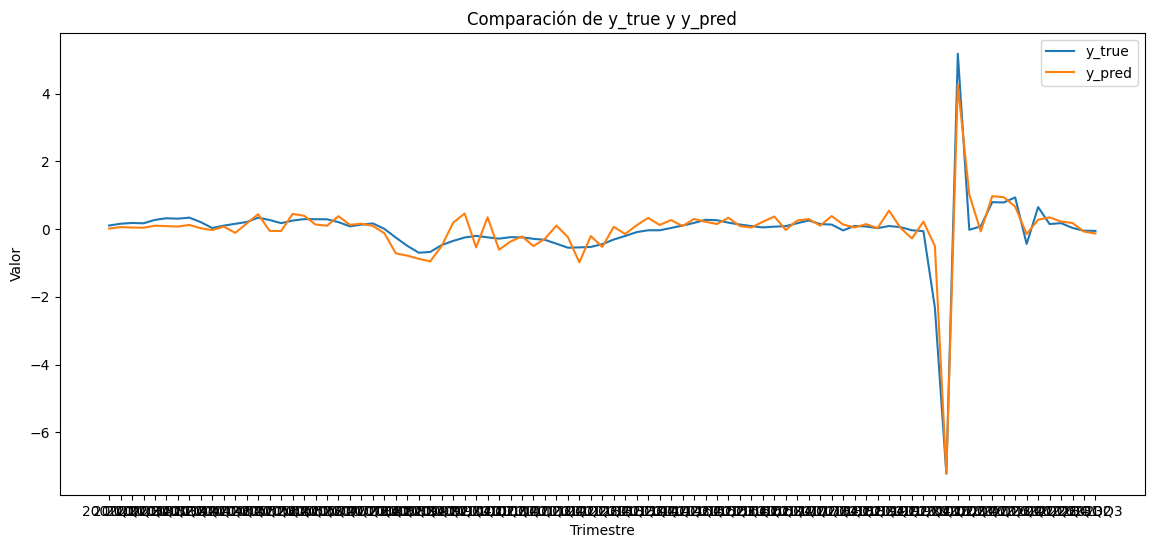

In [26]:

y_true=endog_q['pib']
y_true=y_true['2002Q1':'2023Q3']

X_Q = res.factors.smoothed.resample('Q').mean().loc['2002Q1':'2023Q3']

# Realizar la regresión lineal
modelo = sm.OLS(y_true, X_Q).fit()
print(modelo.summary())

coeficientes_factores = modelo.params.values

# Convertir el índice a una cadena de texto en formato trimestral
y_true.index = y_true.index.to_timestamp().to_period('Q').strftime('%YQ%q')

# Obtener la predicción del modelo
y_pred = modelo.predict(X_Q)

# Graficar y_true y y_pred en el mismo gráfico
plt.figure(figsize=(14, 6))
plt.plot(y_true.index, y_true.values, label='y_true')
plt.plot(y_true.index, y_pred, label='y_pred')
plt.xlabel('Trimestre')
plt.ylabel('Valor')
plt.title('Comparación de y_true y y_pred')
plt.legend()
plt.show()

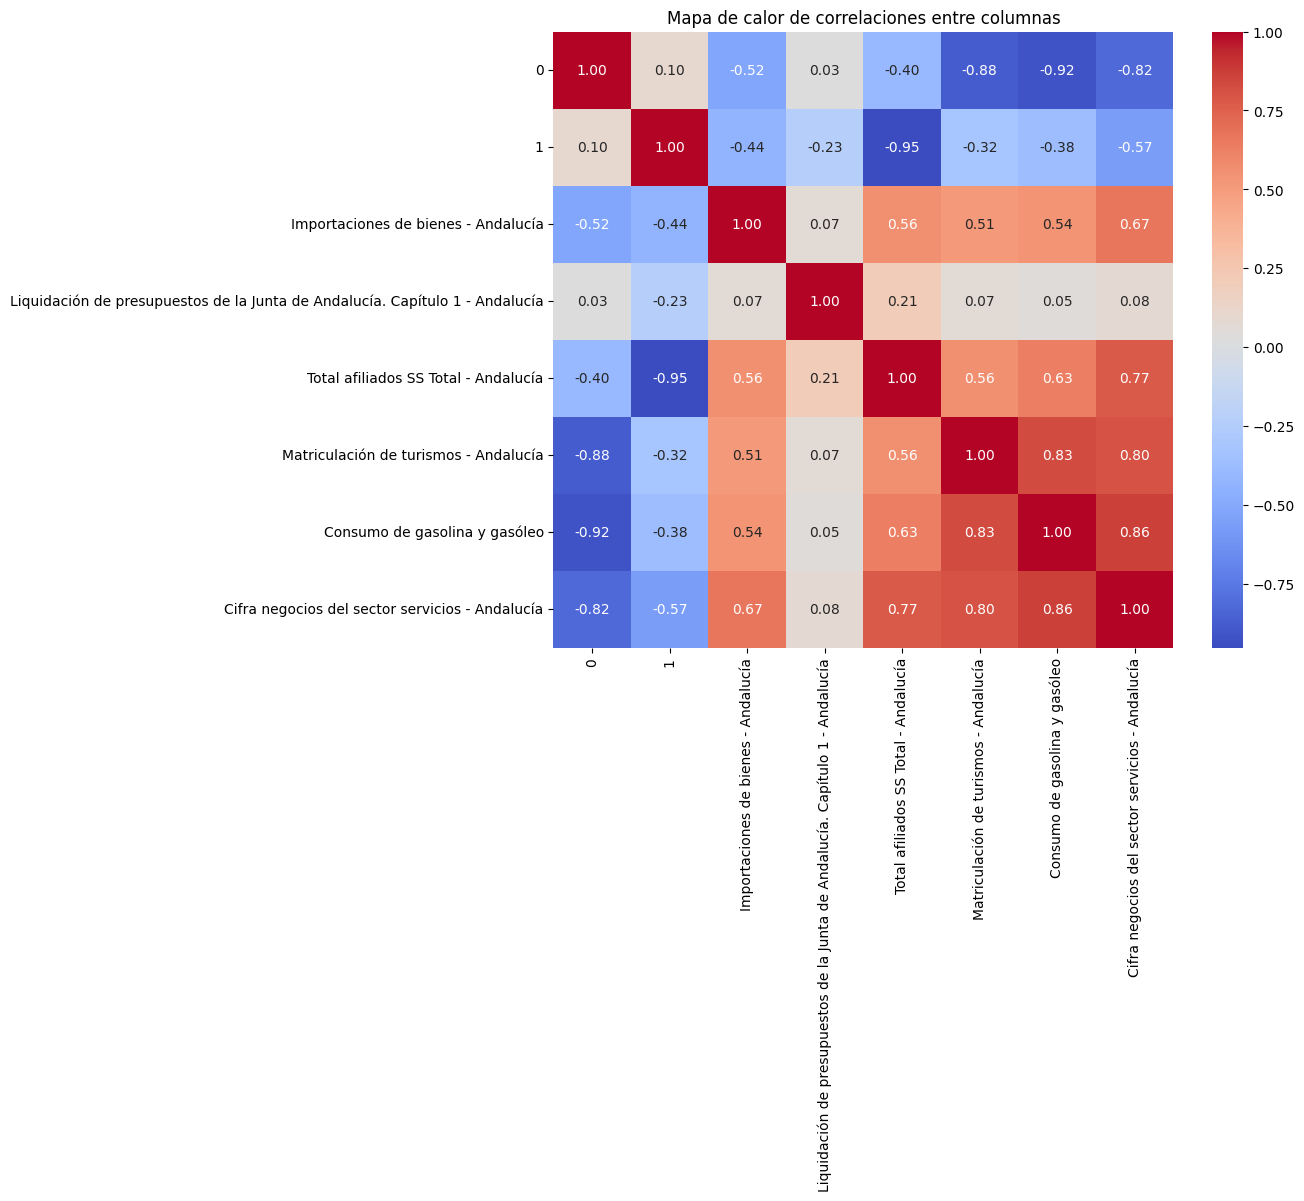

In [32]:
X_Q = res.factors.smoothed
data = pd.merge(X_Q, endog_m_c, left_index=True, right_index=True, how='inner') 
data = data.dropna()



# Calcular las correlaciones
correlation_matrix = data.corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de calor de correlaciones entre columnas')
plt.show()

In [28]:

# Realizar la regresión lineal
factor1 = sm.OLS(data['0'], data[mejores_regresores]).fit()
coeficientes_fac1 = factor1.params.values
print(factor1.summary())

                                 OLS Regression Results                                
Dep. Variable:                      0   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              2325.
Date:                Sun, 19 May 2024   Prob (F-statistic):                   2.11e-190
Time:                        14:16:36   Log-Likelihood:                          126.47
No. Observations:                 218   AIC:                                     -240.9
Df Residuals:                     212   BIC:                                     -220.6
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                                                                                   coef    std err          t      P>|t|

In [29]:

# Realizar la regresión lineal
factor2 = sm.OLS(data['1'], data[mejores_regresores]).fit()
coeficientes_fac2 = factor2.params.values
print(factor2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      1   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              1552.
Date:                Sun, 19 May 2024   Prob (F-statistic):                   3.83e-172
Time:                        14:16:40   Log-Likelihood:                         -129.03
No. Observations:                 218   AIC:                                      270.1
Df Residuals:                     212   BIC:                                      290.4
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                                                                                   coef    std err          t      P>|t|

In [30]:
rsquared = res.get_coefficients_of_determination(method='individual')

top_ten = []
for factor_name in rsquared.columns[:6]:
    top_factor = (rsquared[factor_name].sort_values(ascending=False)
                                       .iloc[:30].round(2).reset_index())
    top_factor.columns = pd.MultiIndex.from_product([
        [f'Top ten variables explained by {factor_name}'],
        ['Variable', r'$R^2$']])
    top_ten.append(top_factor)
pd.concat(top_ten, axis=1)

Top ten variables explained by 0        \
                                            Variable $R^2$   
0                      Consumo de gasolina y gasóleo  0.85   
1              Matriculación de turismos - Andalucía  0.77   
2                                                pib  0.74   
3    Cifra negocios del sector servicios - Andalucía  0.67   
4                Importaciones de bienes - Andalucía  0.27   
5               Total afiliados SS Total - Andalucía  0.16   
6  Liquidación de presupuestos de la Junta de And...  0.00   

                    Top ten variables explained by 1        
                                            Variable $R^2$  
0               Total afiliados SS Total - Andalucía  0.91  
1    Cifra negocios del sector servicios - Andalucía  0.32  
2                                                pib  0.24  
3                Importaciones de bienes - Andalucía  0.19  
4                      Consumo de gasolina y gasóleo  0.14  
5              Matriculación de turismos - Andalucía  0.10  
6  Liquidación de presupuestos de la Junta de And...  0.06

Construcción del ISEA

In [64]:
coeficientes_factores

array([-0.44694641,  0.15559652])

In [65]:
coeficientes_fac1

array([-0.02652332, -0.05375991,  0.00769819, -0.00493518, -0.30764694,
       -0.51855679, -0.59451877, -0.37554074, -0.59895563, -0.08972077])

In [66]:
coeficientes_fac2

array([ 0.01327347,  0.05184756,  0.02085049, -0.01024361,  0.17378173,
       -1.70483535,  0.48457632,  0.27633364,  0.54292339, -0.08177431])

In [67]:
pesos1 = np.stack((coeficientes_fac1, coeficientes_fac2))

In [72]:
pesos = np.dot(coeficientes_factores, pesos1)

In [94]:

# Multiplicar los pesos por las columnas y sumarlos
serie = np.dot(data[mejores_regresores], pesos)


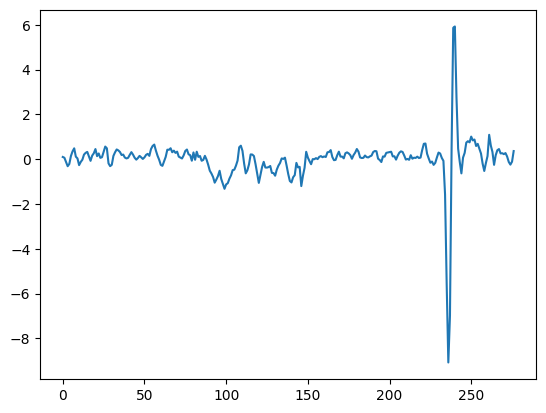

In [97]:
plt.plot(serie)

In [99]:
pesos

array([ 1.39198099e-02,  3.20951001e-02, -1.96416199e-04,  6.11889255e-04,
        1.64541529e-01, -3.34993541e-02,  3.41116421e-01,  2.10843138e-01,
        3.52178058e-01,  2.73765762e-02])